In [1]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Function that computes percentiles of average template intensities in selected
#structures.
def get_median_template_intensity(mouse_connectivity_cache, structure_ids):
    
    mask = mouse_connectivity_cache.get_reference_space().make_structure_mask(structure_ids)
    template, _ = mouse_connectivity_cache.get_template_volume()
                        
    return np.percentile(template[mask > 0].flat, 50, interpolation='lower')

In [3]:
def axis_proj(data, template, axis, bg_q=90, bg_alpha=0.5):
    # let's make some pictures
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    plt.imshow(data_max, interpolation='none', cmap=plt.cm.afmhot)
    plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)

In [4]:
# function that determines the density of signal within a structure (i.e. the fraction of pixels
# in all the voxels in that structure that were detected as signal).
def fraction_of_structure(mouse_connectivity_cache, structure_id, experiment_id):
    
    mask, _ = mouse_connectivity_cache.get_structure_mask(structure_id)
    
    if mask.sum() == 0:
        return 0.0
    
    projection_density, _ = mouse_connectivity_cache.get_projection_density(experiment_id)
    projection_density[mask == 0] = 0
    
    fraction = projection_density.sum() / mask.sum()
    return fraction

In [5]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
# MouseConnectivityCache has a method for retrieving the adult mouse structure 
# tree as an StructureTree class instance. This is a wrapper around a list of 
# dictionaries, where each dictionary describes a structure. 
# It is principally useful for looking up structures by their properties

# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json') #relative path

In [6]:
# grab the StructureTree instance
structure_tree = mcc.get_structure_tree() # To see only structure sets relevant to the adult mouse brain, use the StructureTree

# get info on some structures
structures = structure_tree.get_structures_by_acronym(['MOs', 'SCs'])# You can also .get_structures_by_name(['Secondary motor area'])

On the connectivity atlas web site, they show most of data at a fairly coarse structure level. They did this by creating a structure set of ~300 structures, which we call the "summary structures". We can use the structure tree to get all of the structures in this set

In [7]:
from allensdk.api.queries.ontologies_api import OntologiesApi

oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
structure_set_ids = structure_tree.get_structure_sets()

In [8]:
# From the above table, "Mouse Connectivity - Summary" has id 167587189 (??)
summary_structures = structure_tree.get_structures_by_set_id([167587189])
pd.DataFrame(summary_structures)

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,FRP,1,6,184,"Frontal pole, cerebral cortex","[997, 8, 567, 688, 695, 315, 184]","[3, 112905828, 688152357, 691663206, 687527945...","[38, 143, 69]"
1,MOp,1,18,985,Primary motor area,"[997, 8, 567, 688, 695, 315, 500, 985]","[112905828, 688152357, 691663206, 687527945, 1...","[31, 157, 90]"
2,MOs,1,24,993,Secondary motor area,"[997, 8, 567, 688, 695, 315, 500, 993]","[112905828, 688152357, 691663206, 687527945, 1...","[31, 157, 90]"
3,SSp-n,1,44,353,"Primary somatosensory area, nose","[997, 8, 567, 688, 695, 315, 453, 322, 353]","[112905828, 688152357, 691663206, 687527945, 1...","[24, 128, 100]"
4,SSp-bfd,1,51,329,"Primary somatosensory area, barrel field","[997, 8, 567, 688, 695, 315, 453, 322, 329]","[112905828, 688152357, 691663206, 687527945, 1...","[24, 128, 100]"
...,...,...,...,...,...,...,...,...
311,FN,1,1097,989,Fastigial nucleus,"[997, 8, 512, 519, 989]","[112905828, 691663206, 687527945, 12, 68815236...","[255, 253, 188]"
312,IP,1,1098,91,Interposed nucleus,"[997, 8, 512, 519, 91]","[112905828, 691663206, 687527945, 12, 68815236...","[255, 253, 188]"
313,DN,1,1099,846,Dentate nucleus,"[997, 8, 512, 519, 846]","[112905828, 691663206, 687527945, 12, 68815236...","[255, 253, 188]"
314,VeCB,1,1100,589508455,Vestibulocerebellar nucleus,"[997, 8, 512, 519, 589508455]","[112905828, 691663206, 688152368, 184527634, 1...","[255, 253, 188]"


# Structure Signal Unionization

The ProjectionStructureUnionizes API data tells you how much signal there was in a given structure and experiment. It contains the density of projecting signal, volume of projecting signal, and other information. MouseConnectivityCache provides methods for querying and storing this data.

In [9]:
# find wild-type injections into primary visual area
aud = structure_tree.get_structures_by_acronym(['AUD'])[0] #aud id: 247
print(aud)

aud_experiments = mcc.get_experiments(cre=False, 
                                       injection_structure_ids=[aud['id']])

print("%d AUD experiments" % len(aud_experiments))

{'acronym': 'AUD', 'graph_id': 1, 'graph_order': 121, 'id': 247, 'name': 'Auditory areas', 'structure_id_path': [997, 8, 567, 688, 695, 315, 247], 'structure_set_ids': [3, 112905828, 691663206, 12, 184527634, 114512891], 'rgb_triplet': [1, 147, 153]}
9 AUD experiments


In [10]:
# Step 1: Get the structure ID for the secondary motor area (MOs)
mosa = structure_tree.get_structures_by_acronym(['MOs'])[0]
mosa_id = mosa['id']
print("MOs ID:", mosa_id)

for exp in aud_experiments:
    print(f"Experiment ID: {exp['id']}, Additional Info: {exp}")


MOs ID: 993
Experiment ID: 180073473, Additional Info: {'gender': 'M', 'injection_structures': [541, 1002, 1027], 'injection_volume': 0.0883098188, 'injection_x': 8470, 'injection_y': 2740, 'injection_z': 9750, 'product_id': 5, 'specimen_name': '378-1817', 'strain': 'C57BL/6J', 'structure_abbrev': 'AUDpo', 'structure_id': 1027, 'structure_name': 'Posterior auditory area', 'transgenic_line': None, 'transgenic_line_id': None, 'id': 180073473, 'primary_injection_structure': 1027}
Experiment ID: 146858006, Additional Info: {'gender': 'M', 'injection_structures': [1002, 1027], 'injection_volume': 0.1141708428, 'injection_x': 8170, 'injection_y': 2530, 'injection_z': 9650, 'product_id': 5, 'specimen_name': '378-1506', 'strain': 'C57BL/6J', 'structure_abbrev': 'AUDp', 'structure_id': 1002, 'structure_name': 'Primary auditory area', 'transgenic_line': None, 'transgenic_line_id': None, 'id': 146858006, 'primary_injection_structure': 1002}
Experiment ID: 112881858, Additional Info: {'gender': 'M

In [11]:
structure_unionizes = mcc.get_structure_unionizes([ e['id'] for e in aud_experiments ], 
                                                  is_injection=False,
                                                  structure_ids=[mosa_id],
                                                  include_descendants=True
                                                 #you can add hemisphere_ids: Left = 1, Right = 2, Both = 3. If None, include all records [1, 2, 3]. Default None
                                                 )

print("%d AUD non-injection, MOs structure unionizes" % len(structure_unionizes))

162 AUD non-injection, MOs structure unionizes


In [12]:
sorted_unionizes = structure_unionizes.sort_values(by='projection_density', ascending=False)
sorted_unionizes.head(15)

,experiment_id,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
63,158314278,2,628611778,False,0.654114,5320,810,6270,0.154097,0.036583,24.843025,679.082886,0.046795,656,2.056607e+11,1.044192e+09,2.594088e+10,3.819987e+07,1.279135
151,115958825,2,633501852,False,0.744970,5490,790,6090,0.192751,0.031651,28.742626,908.100464,0.040486,656,2.267059e+11,1.044192e+09,3.001281e+10,3.305010e+07,1.279135
152,115958825,2,633502081,False,0.801121,5470,960,6030,0.222478,0.022284,16.995562,762.695068,0.046730,962,4.194493e+11,1.711904e+09,2.909477e+10,3.814732e+07,2.097083
67,158314278,3,628618239,False,0.654114,5320,810,6270,0.156761,0.018608,12.542169,674.024825,0.047604,656,3.921555e+11,2.088383e+09,2.619286e+10,3.886037e+07,2.558270
150,115958825,2,633502113,False,0.801121,5470,960,6030,0.594319,0.017288,12.905149,746.480291,0.124834,993,1.320614e+12,5.894563e+09,7.607021e+10,1.019052e+08,7.220839
153,115958825,3,633503581,False,0.744970,5490,790,6090,0.208340,0.017106,15.031480,878.745162,0.043761,656,4.020178e+11,2.088383e+09,3.139149e+10,3.572309e+07,2.558270
19,146858006,2,633907502,False,0.574212,5380,750,6320,0.161493,0.014414,6.799969,471.754028,0.018438,656,1.471427e+11,1.044192e+09,7.100471e+09,1.505121e+07,1.279135
54,158314278,2,628612448,False,0.702727,4620,1090,6550,0.098421,0.014252,8.683784,609.301331,0.029888,962,3.856005e+11,1.711904e+09,1.486581e+10,2.439812e+07,2.097083
71,158314278,2,628612524,False,0.702727,4620,1090,6550,0.317071,0.013334,8.729997,654.697447,0.096286,993,1.332889e+12,5.894563e+09,5.145952e+10,7.860045e+07,7.220839
158,115958825,2,633502138,False,0.630107,5810,1440,6620,0.081222,0.013016,6.452400,495.733887,0.017060,1021,1.722456e+11,1.069978e+09,6.903929e+09,1.392668e+07,1.310724


You can filter it down to a smaller list of structures like this.

In [13]:
dense_unionizes = structure_unionizes[ structure_unionizes.projection_density > .01 ]
large_unionizes = dense_unionizes[ dense_unionizes.volume > .5 ]
large_structures = pd.DataFrame(structure_tree.nodes(large_unionizes.structure_id))

print("%d large, dense, Mos, non-injection unionizes, %d structures" % ( len(large_unionizes), len(large_structures) ))

print(large_structures.name)

large_unionizes.head()

11 large, dense, Mos, non-injection unionizes, 11 structures
0       Secondary motor area, layer 1
1     Secondary motor area, layer 2/3
2       Secondary motor area, layer 1
3       Secondary motor area, layer 1
4                Secondary motor area
5                Secondary motor area
6       Secondary motor area, layer 1
7     Secondary motor area, layer 2/3
8       Secondary motor area, layer 1
9      Secondary motor area, layer 6a
10    Secondary motor area, layer 2/3
Name: name, dtype: object


,experiment_id,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
19,146858006,2,633907502,False,0.574212,5380,750,6320,0.161493,0.014414,6.799969,471.754028,0.018438,656,1.471427e+11,1.044192e+09,7.100471e+09,1.505121e+07,1.279135
54,158314278,2,628612448,False,0.702727,4620,1090,6550,0.098421,0.014252,8.683784,609.301331,0.029888,962,3.856005e+11,1.711904e+09,1.486581e+10,2.439812e+07,2.097083
63,158314278,2,628611778,False,0.654114,5320,810,6270,0.154097,0.036583,24.843025,679.082886,0.046795,656,2.056607e+11,1.044192e+09,2.594088e+10,3.819987e+07,1.279135
67,158314278,3,628618239,False,0.654114,5320,810,6270,0.156761,0.018608,12.542169,674.024825,0.047604,656,3.921555e+11,2.088383e+09,2.619286e+10,3.886037e+07,2.558270
71,158314278,2,628612524,False,0.702727,4620,1090,6550,0.317071,0.013334,8.729997,654.697447,0.096286,993,1.332889e+12,5.894563e+09,5.145952e+10,7.860045e+07,7.220839


# Generating a Projection Matrix

The MouseConnectivityCache class provides a helper method for converting ProjectionStructureUnionize records for a set of experiments and structures into a matrix.

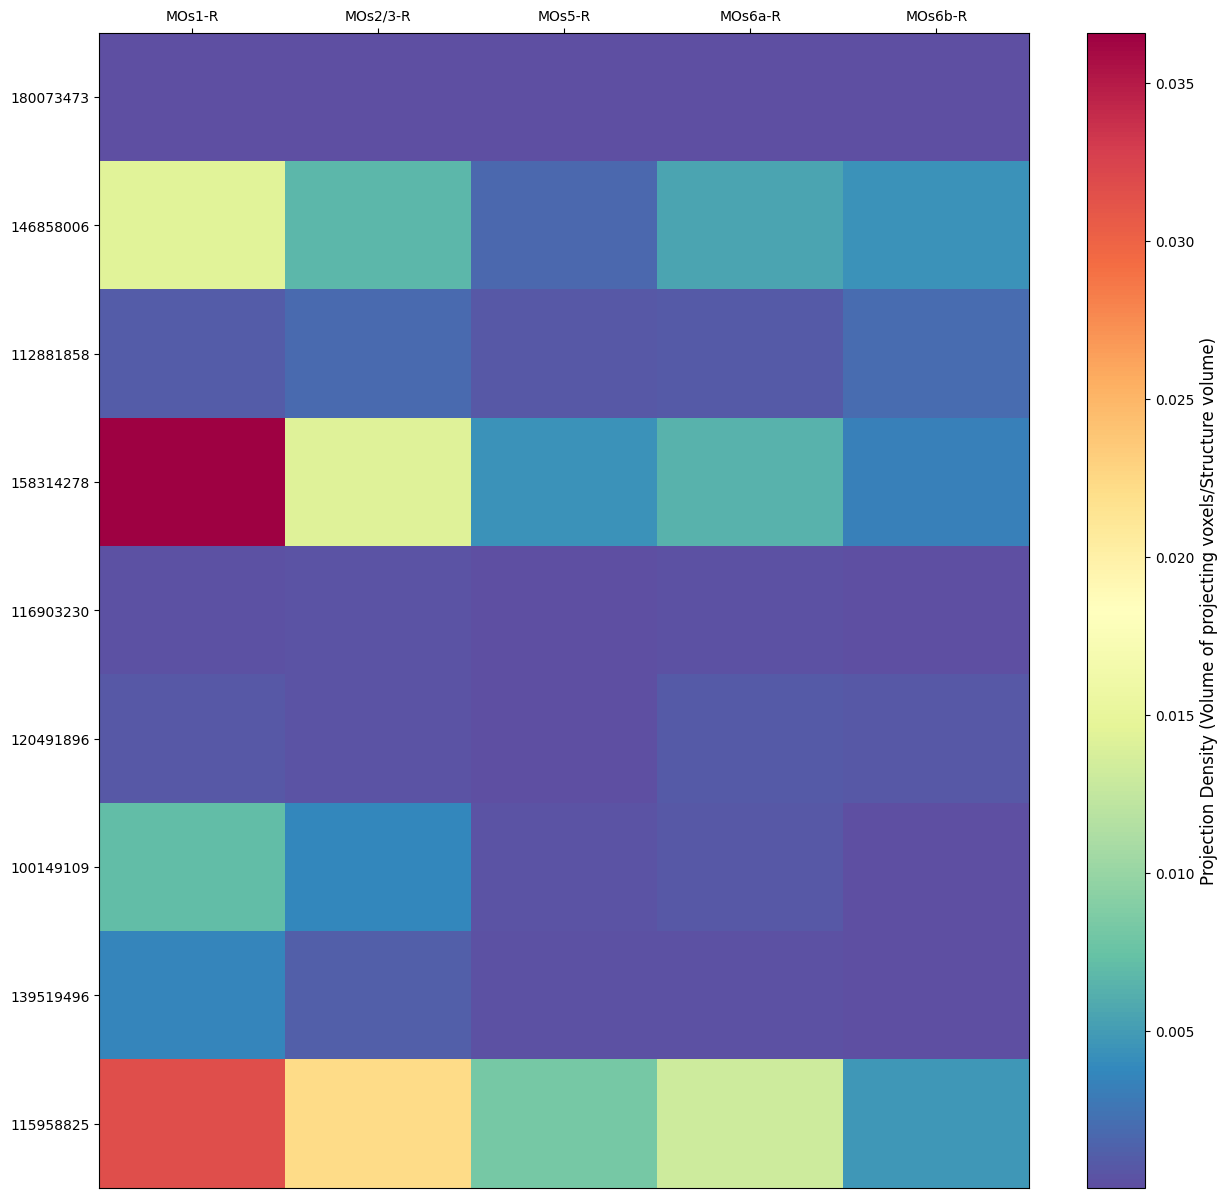

In [14]:
# This code snippet demonstrates how to make a matrix of projection
# density values in Secondary Motor Area for cre-negative VISp experiments.

aud_experiment_ids = [ e['id'] for e in aud_experiments ]
ctx_children = structure_tree.child_ids( [993] )[0] #993 = MOs id

pm = mcc.get_projection_matrix(experiment_ids = aud_experiment_ids, 
                               projection_structure_ids = ctx_children,
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_density')

row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(15,15))
heatmap = ax.pcolor(matrix, cmap=plt.cm.Spectral_r)

# Add a colorbar to the plot
colorbar = plt.colorbar(heatmap, ax=ax)
colorbar.set_label('Projection Density (Volume of projecting voxels/Structure volume)', fontsize=12)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)

# Save the plot as a PNG file
output_filename = "projection_matrix.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

#Show the plot
plt.show()

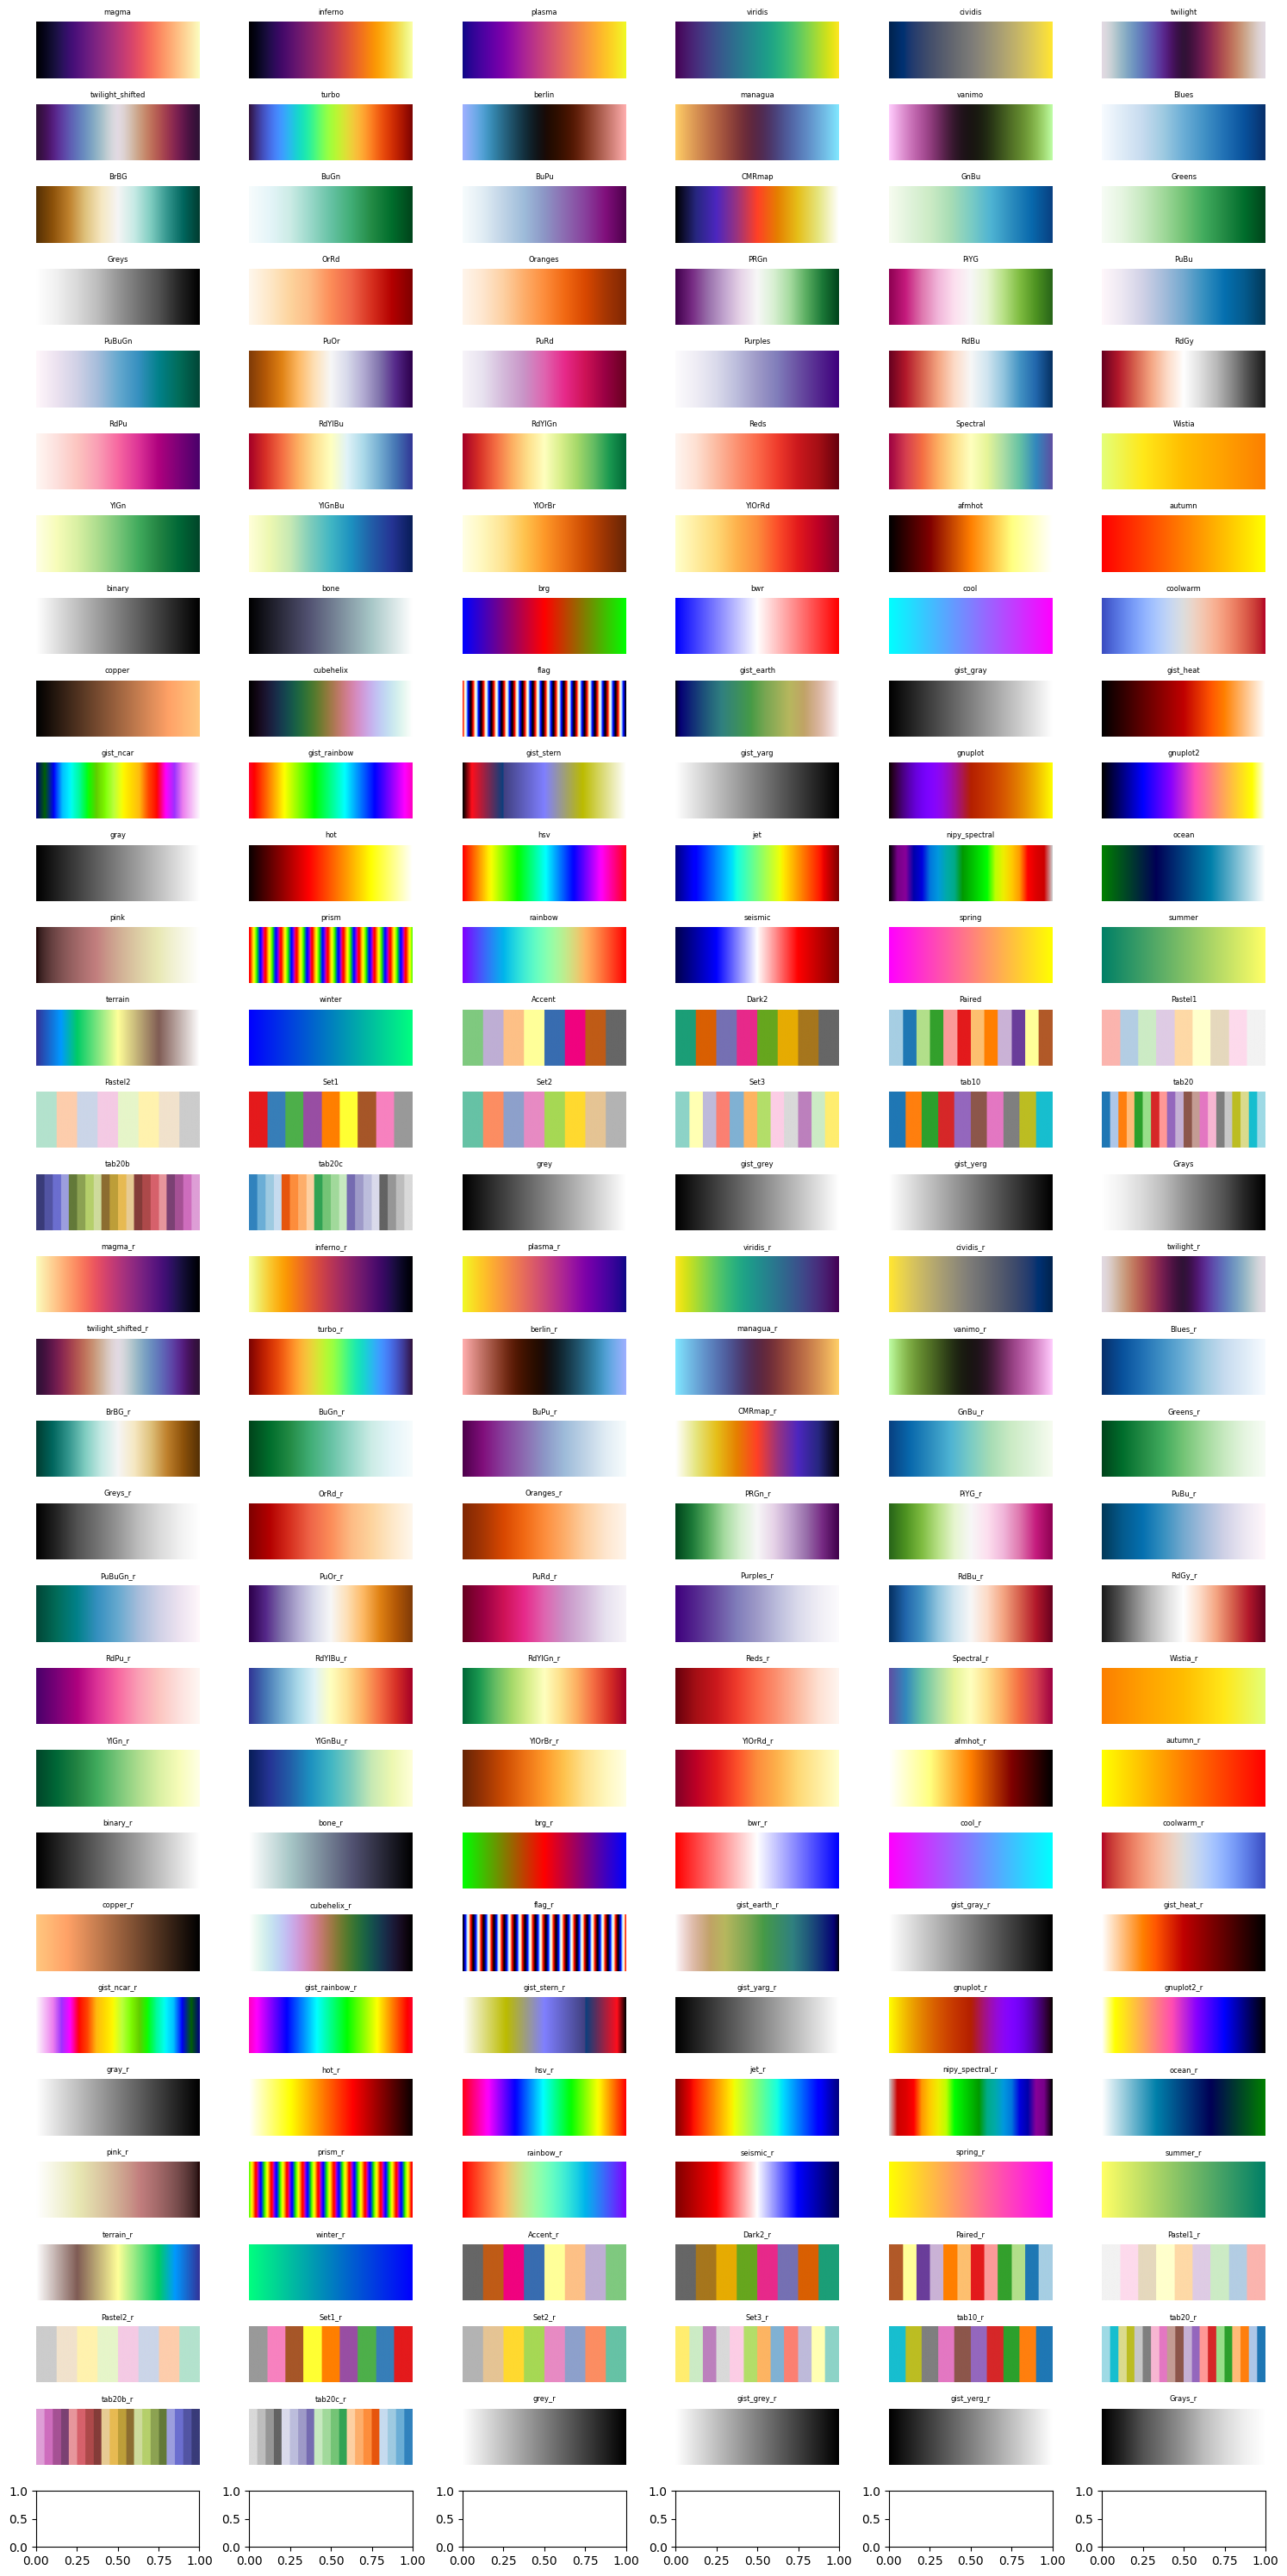

In [51]:
#To know which color palettes are available for the matrix
colormaps = plt.colormaps()
gradient = np.linspace(0, 1, 256).reshape(1, -1)

fig, axes = plt.subplots(len(colormaps)//6 + 1, 6, figsize=(15, len(colormaps)//6))
axes = axes.flatten()

for ax, cmap in zip(axes, colormaps):
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_title(cmap, fontsize=6)
    ax.axis('off')

plt.tight_layout()
plt.show()

             MOs1-R  MOs2/3-R    MOs5-R   MOs6a-R   MOs6b-R
180073473  0.000090  0.000047  0.000031  0.000031  0.000014
146858006  0.014414  0.006607  0.001641  0.005468  0.004344
112881858  0.000924  0.001834  0.000727  0.000821  0.001958
158314278  0.036583  0.014252  0.004428  0.006435  0.003185
116903230  0.000158  0.000371  0.000121  0.000235  0.000025
120491896  0.000708  0.000334  0.000157  0.000830  0.000681
100149109  0.007080  0.003640  0.000414  0.000643  0.000106
139519496  0.003501  0.001120  0.000167  0.000204  0.000071
115958825  0.031651  0.022284  0.008170  0.013016  0.004602


[Text(0, 0.5, '180073473'),
 Text(0, 1.5, '146858006'),
 Text(0, 2.5, '112881858'),
 Text(0, 3.5, '158314278'),
 Text(0, 4.5, '116903230'),
 Text(0, 5.5, '120491896'),
 Text(0, 6.5, '100149109'),
 Text(0, 7.5, '139519496'),
 Text(0, 8.5, '115958825')]

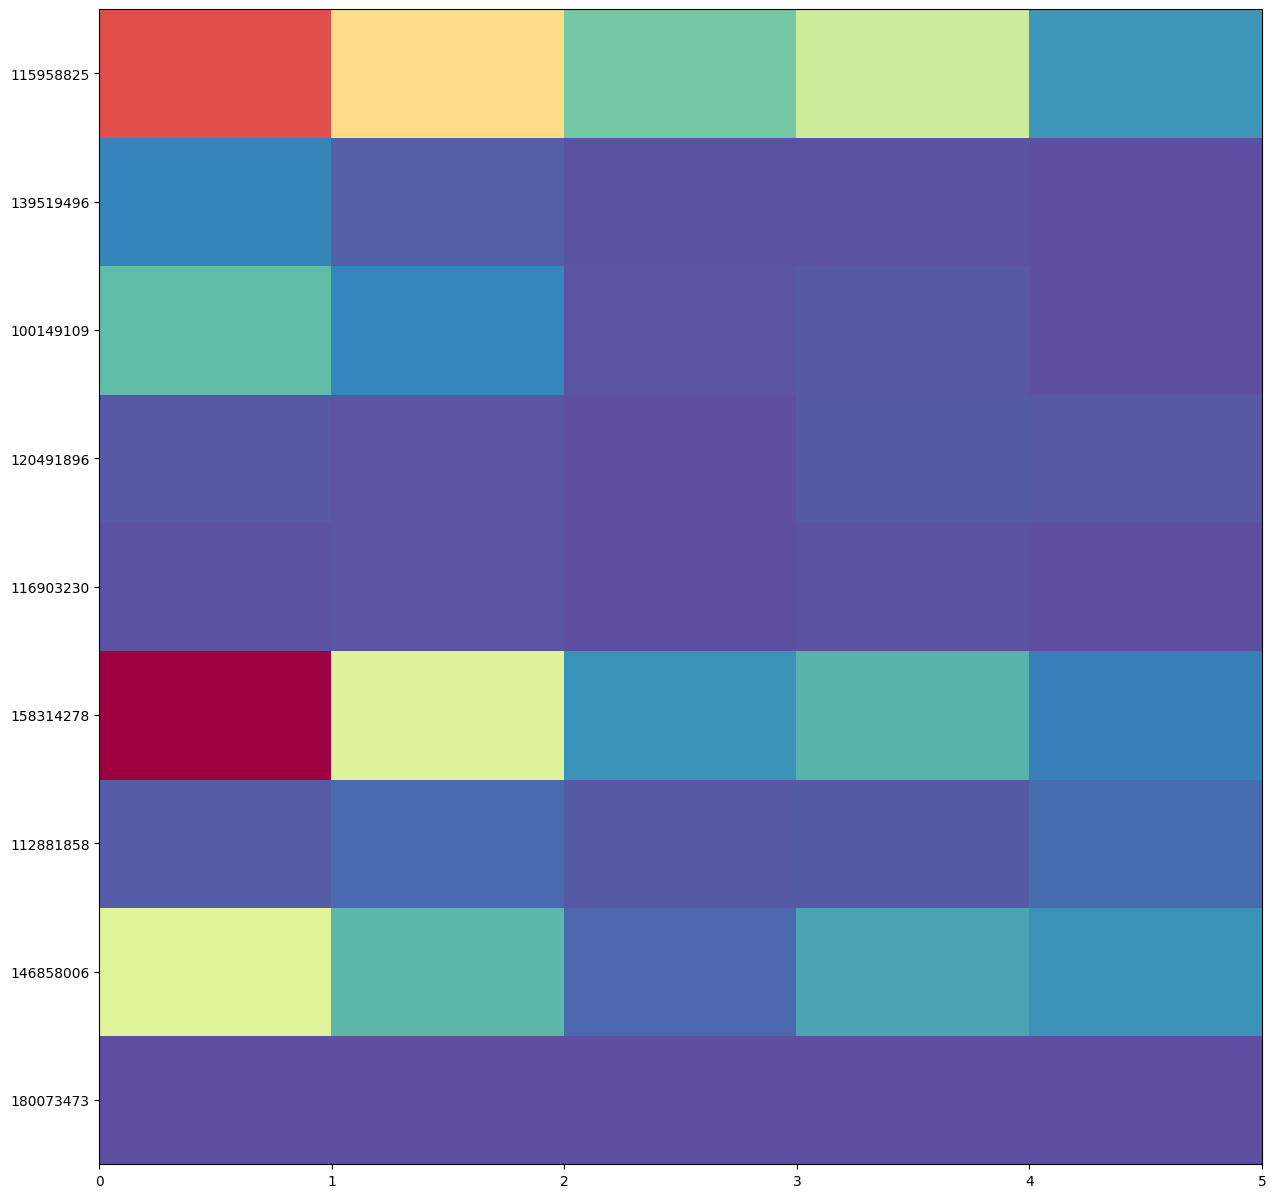

In [16]:
# Convert matrix to a NumPy array
matrix = np.array(matrix)

# Visualize projection density values
df_matrix = pd.DataFrame(matrix, index=row_labels, columns=column_labels)
print(df_matrix)

# Identify rows where all values are zero
non_zero_row_indices = np.any(matrix != 0, axis=1) 

# Filter rows and labels
filtered_matrix = matrix[non_zero_row_indices, :]
filtered_row_labels = [row_labels[i] for i in range(len(row_labels)) if non_zero_row_indices[i]]

# Update the heatmap with the filtered data
fig, ax = plt.subplots(figsize=(15, 15))
heatmap = ax.pcolor(filtered_matrix, cmap=plt.cm.Spectral_r)

# Update y-tick labels
ax.set_yticks(np.arange(filtered_matrix.shape[0]) + 0.5, minor=False)
ax.set_yticklabels(filtered_row_labels, minor=False)

In [17]:
#Projection matrix but with projection volume data
pm_volume = mcc.get_projection_matrix(experiment_ids = visp_experiment_ids, 
                               projection_structure_ids = ctx_children,
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_volume') 

row_labels = pm_volume['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm_volume['columns'] ] 
matrix = pm_volume['matrix']

fig, ax = plt.subplots(figsize=(15,15))
heatmap = ax.pcolor(matrix, cmap=plt.cm.Spectral_r)

# Add a colorbar to the plot
colorbar = plt.colorbar(heatmap, ax=ax)
colorbar.set_label('Projection Volume (Volume of projecting voxels in mm^3)', fontsize=12)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

NameError: name 'visp_experiment_ids' is not defined

# Manipulating Grid Data

The MouseConnectivityCache class also helps you download and open every experiment's projection grid data volume. By default it will download 25um volumes, but you could also download data at other resolutions if you prefer (10um, 50um, 100um).

This demonstrates how you can load the projection density for a particular experiment. It also shows how to download the template volume to which all grid data is registered. Voxels in that template have been structurally annotated by neuroanatomists and the resulting labels stored in a separate annotation volume image.

In [20]:
# injection into AUD as example
experiment_id = 146858006

In [8]:
# projection density: number of projecting pixels / voxel volume
pd, pd_info = mcc.get_projection_density(experiment_id)

# injection density: number of projecting pixels in injection site / voxel volume
ind, ind_info = mcc.get_injection_density(experiment_id)

# injection fraction: number of pixels in injection site / voxel volume
inf, inf_info = mcc.get_injection_fraction(experiment_id)

# data mask:
# binary mask indicating which voxels contain valid data
dm, dm_info = mcc.get_data_mask(experiment_id)

template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

# in addition to the annotation volume, you can get binary masks for individual structures
# in this case, we'll get one for the MOs
cortex_mask, cm_info = mcc.get_structure_mask(993)

print(pd_info)
print(pd.shape, template.shape, annot.shape)

NameError: name 'experiment_id' is not defined

In [ ]:
# compute the maximum intensity projection (along the anterior-posterior axis) of the projection data
pd_mip = pd.max(axis=0)
ind_mip = ind.max(axis=0)
inf_mip = inf.max(axis=0)

# show that slice of all volumes side-by-side
f, pr_axes = plt.subplots(1, 3, figsize=(15, 6))

pr_axes[0].imshow(pd_mip, cmap='hot', aspect='equal')
pr_axes[0].set_title("projection density MaxIP")

pr_axes[1].imshow(ind_mip, cmap='hot', aspect='equal')
pr_axes[1].set_title("injection density MaxIP")

pr_axes[2].imshow(inf_mip, cmap='hot', aspect='equal')
pr_axes[2].set_title("injection fraction MaxIP")

plt.show()

In [ ]:
# Look at a slice from the average template and annotation volumes

# pick a slice to show
slice_idx = 210

f, ccf_axes = plt.subplots(1, 3, figsize=(15, 6))

ccf_axes[0].imshow(template[slice_idx,:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ccf_axes[0].set_title("registration template")

ccf_axes[1].imshow(annot[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
ccf_axes[1].set_title("annotation volume")

ccf_axes[2].imshow(cortex_mask[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=1)
ccf_axes[2].set_title("MOs mask")

plt.show()

On occasion the TissueCyte microscope fails to acquire a tile. In this case the data from that tile should not be used for analysis. The data mask associated with each experiment can be used to determine which portions of the grid data came from correctly acquired tiles.

In this experiment, a missed tile can be seen in the data mask as a dark warped square. The values in the mask exist within [0, 1], describing the fraction of each voxel that was correctly acquired

In [ ]:
f, data_mask_axis = plt.subplots(figsize=(5, 6))

data_mask_axis.imshow(dm[81, :, :], cmap='hot', aspect='equal', vmin=0, vmax=1)
data_mask_axis.set_title('data mask')

plt.show()

# Working in 3D
Allen Institute has generated an average template volume from 1675 mouse brain image stacks and registering each connectivity datasets to this average template. This allows us to work in a shared 3d space, which we call the Common Coordinate Framework (CCF).
You can view the average template volume using your MouseConnectivityCache:

(528, 320, 456)


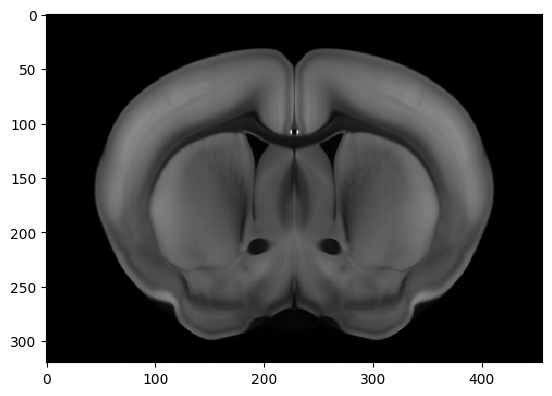

In [9]:
# load up the average template
template, header = mcc.get_template_volume()

# recall that this cache is at 25 micron isometric resolution
plt.imshow(template[200, :, :], interpolation='none', cmap=plt.cm.gray)

# how big?
print(template.shape)

The template is oriented:

anterior -> posterior

superior -> inferior

left -> right

This means that to obtain a sagittal view, we must slice along axis 2, and along axis 1 for a horizontal section (0=coronal, 1=horizontal, 2=sagittal):

In [ ]:
#Sagittal view
plt.imshow(template[:, :, 125].T, interpolation='none', cmap=plt.cm.gray)

In [ ]:
#Horizontal/longitudinal view
plt.imshow(template[:, 75, :], interpolation='none', cmap=plt.cm.gray)

# The annotation volume

Each (brain) voxel in the CCF is associated with a structure in the structure tree. This mapping is recorded in the annotation volume, which occupies the same space as the average template. The value of each voxel in the annotation volume is the id of the most specific structure occupying that point in space.

In [ ]:
# you can obtain a reference space object from your mouse connectivity cache
# this object handles tasks that require both a structure tree and an annotation volume
reference_space =  mcc.get_reference_space()

# One such task is to apply our predefined structure colors to 
# a slice from the annotation volume
slice_image = reference_space.get_slice_image(1, 1875) # this method wants an axis and a position in microns
plt.imshow(slice_image, interpolation='none')

In [ ]:
import pandas as pd

# you can load up the raw annotation using your MouseConnectivityCache
annotation, _ = mcc.get_annotation_volume()

#I want to find MOs (id=993)

np.where(annotation == 993) #only this would not show up anything, annotation only labels finest structure division at each voxel
MOs_children = structure_tree.children([993])[0]

pd.DataFrame(MOs_children)


In [ ]:
# VISp, like other cortical structures, is subdivided into layers. 
# Voxels are directly assigned to the layer structures instead of to MOs
np.where(annotation==962) # 962 <==> MOs layer 2/3

A couple of caveats regarding the annotation:

It is possible for a structure and its substructures to all be directly annotated. An example would be hypothalamus, which has nuclei labeled where and only where they are distinctly identifiable.

Not all structures in the structure tree are annotated or have annotated substructures.

# Structure Mask
The annotation volume and structure tree contain a lot of information in a compact form. It can be simpler to work with more explicit representations of individual structures. We often use binary indicator masks for specific structures. These are:

volumes in the common coordinate framework

1 where the annotation is labeled with a structure or its descendants, otherwise 0

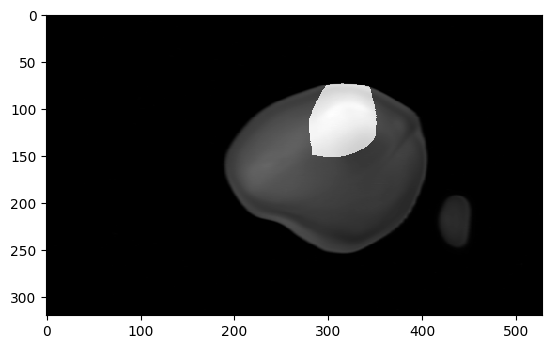

In [22]:
# view a structure mask for VISp
aud_mask, _ = mcc.get_structure_mask(247)
plt.imshow(aud_mask[:, :, 50].T, interpolation='none', cmap=plt.cm.gray)
plt.imshow(template[:, :, 50].T, interpolation='none', cmap=plt.cm.gray, alpha=0.4)

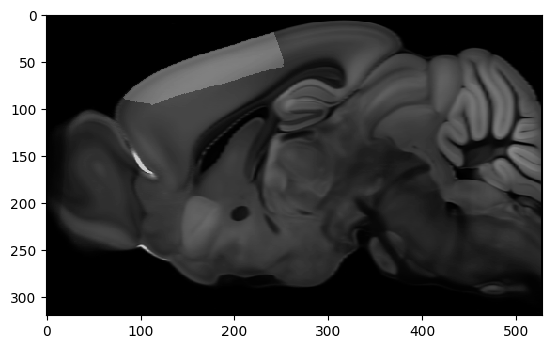

In [23]:
# view a structure mask for MOs
MOs_mask, _ = mcc.get_structure_mask(993)
plt.imshow(MOs_mask[:, :, 200].T, interpolation='none', cmap=plt.cm.gray)
plt.imshow(template[:, :, 200].T, interpolation='none', cmap=plt.cm.gray, alpha=0.8)

In [24]:
# we can now easily locate VISp/MOs-labeled voxels in space:
aud_voxel_coord = np.where(aud_mask)

MOs_voxel_coord = np.where(MOs_mask)

print(aud_voxel_coord)
print(MOs_voxel_coord)

(array([276, 276, 276, ..., 354, 354, 354], dtype=int64), array([109, 109, 110, ..., 123, 123, 123], dtype=int64), array([ 35, 421,  34, ...,  28, 427, 428], dtype=int64))
(array([ 77,  77,  77, ..., 258, 258, 258], dtype=int64), array([ 94, 109, 110, ...,  58,  58,  58], dtype=int64), array([278, 299, 156, ..., 261, 262, 263], dtype=int64))


In [25]:
#We can use the coordinates to extrapolate the mask of the roi

visp_template = template.copy()

# we use 0 here for the masked value because pyplot.imshow doesn't play nice with nan.
# This is not necessarily the right choice for your application!
visp_template[visp_mask == 0] = 0
plt.imshow(visp_template[:, :, 125].T, interpolation='none', cmap=plt.cm.gray)

NameError: name 'visp_mask' is not defined

In [ ]:
MOs_template = template.copy()
MOs_template[MOs_mask == 0] = 0
plt.imshow(MOs_template[:, :, 125].T, interpolation='none', cmap=plt.cm.gray)

In [ ]:

# We can now ask questions about the template while restricting our inquiry to VISp
# for instance, to find the mean voxelwise template intensity within visp:
visp_template.sum() / np.count_nonzero(visp_mask)
visp_template[visp_mask == 0] = 0
plt.imshow(visp_template[:, :, 125].T, interpolation='none', cmap=plt.cm.gray)

In [ ]:
#Use get_median_template_intensity function to compare the median intensity in white and gray matter.

# find the appropriate ids
structure_tree.get_structures_by_name(['fiber tracts', 'Basic cell groups and regions'])

In [ ]:
#gm = get_median_template_intensity(mcc, [8])
#wm = get_median_template_intensity(mcc, [1009])

#print('gray: ' + str(gm))
#print('white: ' + str(wm))

# Gridded projection data
Since each connectivity experiment is registered to the CCF, we can load connectivity data in the same way as we do the average template or annotation volume.

Here we will load an experiment's projection density volume. These data:

are floats in [0, 1]

represent the fraction of each voxel that is occupied by signal (as detected in the segmentation stage)

are independent of the injection site (so it makes sense to discuss "projection in the injection site")

In [10]:
prdens, _ = mcc.get_projection_density(115958825)

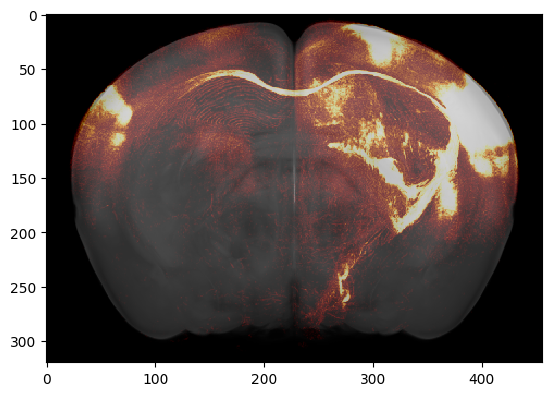

In [11]:
# make a max projection along the anterior-posterior axis for visualization
axis_proj(prdens, template, 0)

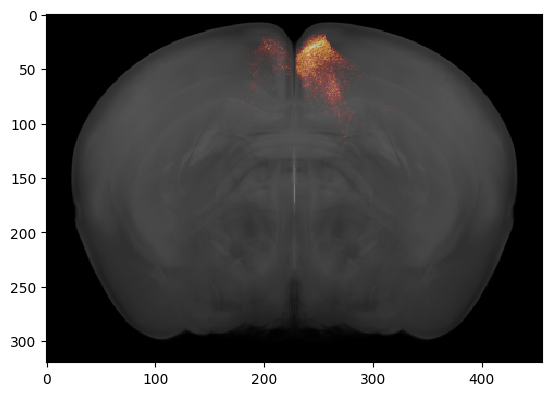

In [16]:
# now filter the signal to MOs
MOs_mask, _ = mcc.get_structure_mask(993)

prdens_MOs = prdens.copy()
prdens_MOs[MOs_mask == 0] = 0
axis_proj(prdens_MOs, template, 0) #coronal

In [ ]:
axis_proj(prdens_MOs, template, 1) #longitudinal

In [ ]:
axis_proj(prdens_MOs, template, 2) #sagittal

In [ ]:
# Another useful data volume is the injection fraction. This shows the fraction of each voxel that lies within
# this experiment's manually annotated injection site
ijfr, _ = mcc.get_injection_fraction(307137980)

In [ ]:
axis_proj(ijfr, template, 0)

In [ ]:
print('MOs', fraction_of_structure(mcc, 993, 307137980))
print('VISp', fraction_of_structure(mcc, 385, 307137980))

In [12]:
#Compute Average Projection Density from multiple experiments
# List of experiment IDs
experiment_ids_aud = [180073473, 146858006, 112881858, 158314278, 116903230, 120491896, 100149109, 139519496, 115958825]  # Replace with actual IDs
#experiment_ids_visp =[180296424, 114008926, 309004492, 309372716, 307558646, 113887162, 
#                      307743253, 307137980, 309113907, 307321674, 307297141, 307593747, 
#                      307296433, 127138787, 307320960, 307557934, 113887868, 309003780, 
#                      126862385, 100141219, 304565427, 272782668, 304586645, 100147853, 
#                      638314843, 174361040, 277714322, 277616630, 277713580, 304564721, 
#                      277712166, 304585910, 304762965]
experiment_ids_vis = [180296424, 100141796, 114008926, 127089669, 309004492, 126861679, 309372716, 307558646,
                      113887162, 100141599, 307743253, 307137980, 307295727, 309113907, 307321674, 120437703,
                      307297141, 307593747, 114250546, 307296433, 127138787, 307320960, 116903968, 100148503,
                      112373830, 307557934, 113887868, 146858755, 309003780, 146077302, 126862385, 100141219,
                      157062358, 304565427, 272782668, 304586645, 100147853, 638314843, 174361040, 277714322,
                      277616630, 277713580, 304564721, 277712166, 304585910, 272916202, 304762965]

# Initialize an array to accumulate projection densities
average_prdens_aud = None
average_prdens_vis = None

# Iterate through experiment IDs
for exp_id in experiment_ids_aud:
    prdens_aud, _ = mcc.get_projection_density(exp_id)  # Load projection density for the experiment
    if average_prdens_aud is None:
        # Initialize the accumulator with the shape of the first experiment's data
        average_prdens_aud = np.zeros_like(prdens_aud, dtype=np.float32)
    average_prdens_aud += prdens_aud

for exp_id in experiment_ids_vis:
    prdens_vis, _ = mcc.get_projection_density(exp_id)  # Load projection density for the experiment
    if average_prdens_vis is None:
        # Initialize the accumulator with the shape of the first experiment's data
        average_prdens_vis = np.zeros_like(prdens_vis, dtype=np.float32)
    average_prdens_vis += prdens_vis
    
# Compute the average
average_prdens_aud /= len(experiment_ids_aud)
average_prdens_vis /= len(experiment_ids_vis)


2025-02-10 20:17:22,643 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/100141796?image=projection_density&resolution=25
2025-02-10 20:17:50,444 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/127089669?image=projection_density&resolution=25
2025-02-10 20:18:55,640 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/126861679?image=projection_density&resolution=25
2025-02-10 20:20:23,643 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/100141599?image=projection_density&resolution=25
2025-02-10 20:21:02,176 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/307295727?image=projection_density&resolution=25
2025-02-10 20:21:49,439 allensdk.api.api.retrieve_file_

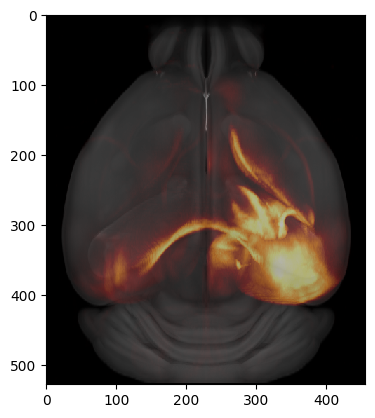

In [14]:
axis_proj(average_prdens_vis, template, 1)

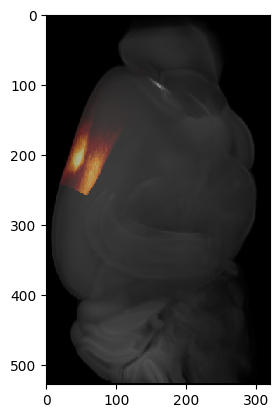

In [19]:
prdens_MOs = average_prdens_vis.copy()
prdens_MOs[MOs_mask == 0] = 0
axis_proj(prdens_MOs, template, 2) #coronal

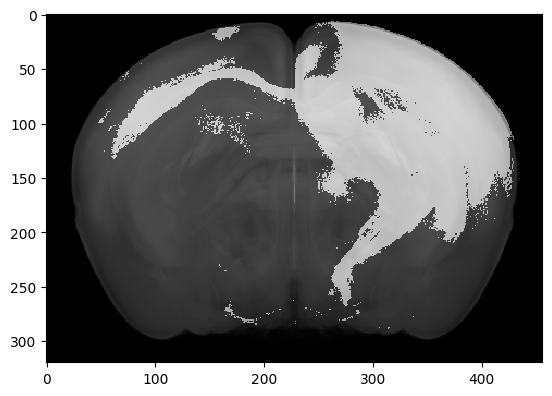

In [20]:
# Define threshold for active pixels (e.g., projection density > 0.1)
threshold = 0.03

# Find active pixels in both datasets
active_aud = average_prdens_aud > threshold
active_vis = average_prdens_vis > threshold

# Find overlap of active pixels
overlap_active = active_aud & active_vis

# Visualize the averaged projection density
axis_proj(overlap_active, template, 0)  # Example: max projection

plt.show()

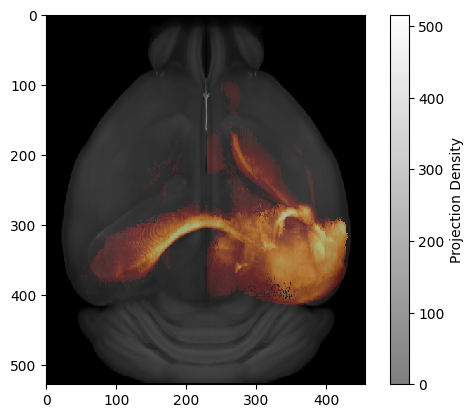

In [22]:
# Identify active pixels in both datasets
active_aud = average_prdens_aud > threshold
active_visp = average_prdens_vis > threshold

# Compute overlap of active pixels
overlap_active = active_aud & active_vis

# Initialize combined projection density map
combined_prdens = np.zeros_like(average_prdens_aud)

# Assign combined densities where overlap is active
combined_prdens[overlap_active] = (
    average_prdens_aud[overlap_active] + average_prdens_vis[overlap_active]
)

# Visualize the averaged projection density
fig, ax = plt.subplots()

# Assuming axis_proj returns an image object; if not, adjust accordingly
image = axis_proj(combined_prdens, template, 1)  # Example: max projection

# Add a colorbar to the plot
cbar = plt.colorbar(image, ax=ax)
cbar.set_label('Projection Density')  # Label for the colorbar

plt.show()

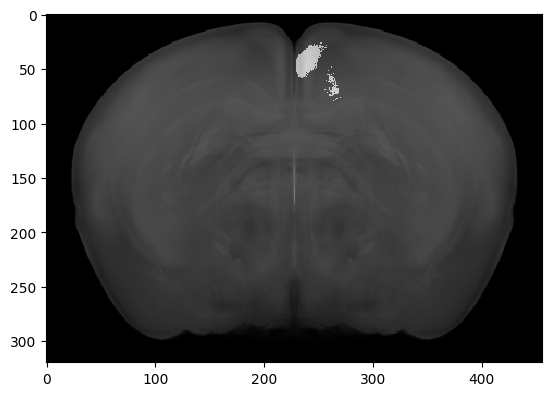

In [23]:
#Filter in MOs

prdens_MOs_average = overlap_active.copy()
prdens_MOs_average[MOs_mask == 0] = 0
axis_proj(prdens_MOs_average, template, 0) #coronal

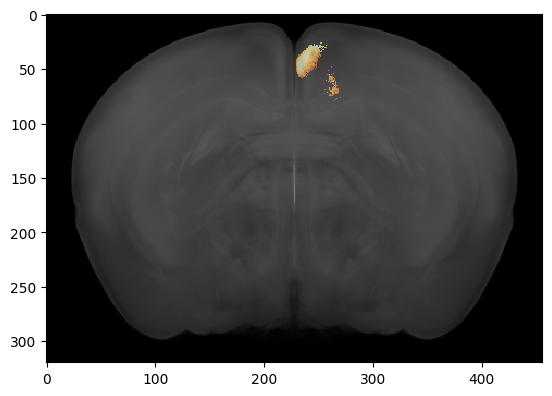

In [24]:
prdens_MOs_average = combined_prdens.copy()
prdens_MOs_average[MOs_mask == 0] = 0
axis_proj(prdens_MOs_average, template, 0) #coronal

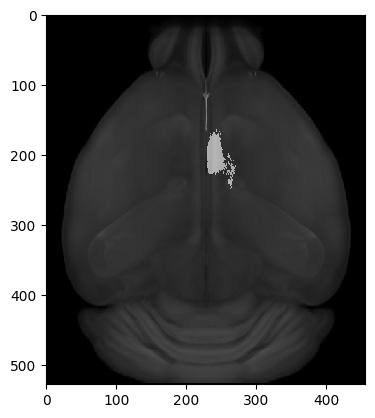

In [25]:
#Filter in MOs

prdens_MOs_average = overlap_active.copy()
prdens_MOs_average[MOs_mask == 0] = 0
axis_proj(prdens_MOs_average, template, 1) #coronal

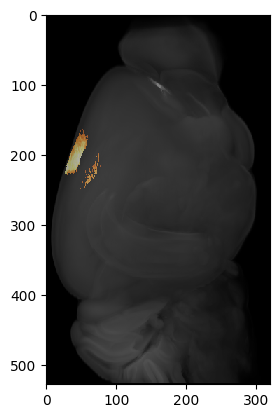

In [26]:
prdens_MOs_average = combined_prdens.copy()
prdens_MOs_average[MOs_mask == 0] = 0
axis_proj(prdens_MOs_average, template, 2) #coronal

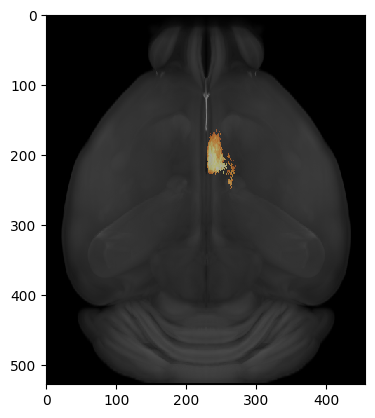

In [27]:
axis_proj(prdens_MOs_average, template, 1) #horizontal

In [ ]:
axis_proj(prdens_MOs_average, template, 2) #sagittal

output_filename = "average_projection_density_aud_MOs_sagittal.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

In [ ]:
#For the injection site
# Initialize an array to accumulate projection densities
average_ijfr = None

# Iterate through experiment IDs
for exp_id in experiment_ids:
    ijfr, _ = mcc.get_injection_fraction(exp_id)  # Load projection density for the experiment
    if average_ijfr is None:
        # Initialize the accumulator with the shape of the first experiment's data
        average_ijfr = np.zeros_like(ijfr, dtype=np.float32)
    average_ijfr += ijfr

# Compute the average
average_ijfr /= len(experiment_ids)

In [ ]:
# Visualize the averaged injection fraction density
axis_proj(average_ijfr, template, 1)  # Example: max projection along anterior-posterior axis